In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

In [20]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
pwd

'e:\\Pill Project\\code\\Model'

In [7]:
# 데이터셋 디렉터리 경로
dataset_dir = 'E:\\Pill Project\\half_data'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

# 사진 크기
image_width = 224
image_height = 224
num_classes = 400

# ImageDataGenerator 초기화
# 0~1 사이로 숫자값 변경
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련셋 제너레이터
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

# 검증셋 제너레이터
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

# 테스트셋 제너레이터
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

Found 207360 images belonging to 400 classes.
Found 51840 images belonging to 400 classes.
Found 25920 images belonging to 400 classes.


In [8]:
# 훈련셋에서 배치를 생성
for data_batch, labels_batch in train_generator:
    break

In [9]:
# 데이터 배치의 크기
# (배치개수, 이미지너비, 이미지높이, RGB채널)
data_batch.shape

(64, 224, 224, 3)

In [10]:
# 라벨 배치의 크기
# (배치개수, 카테고리개수)
labels_batch.shape

(64, 400)

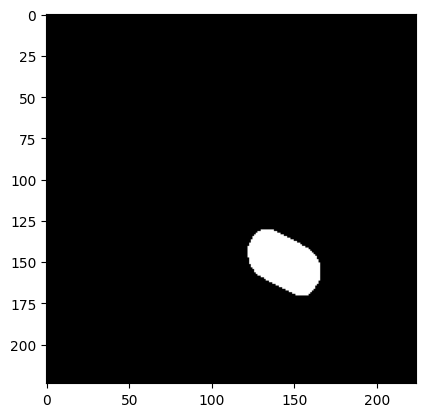

In [11]:
# 첫 번째 이미지 출력
image = data_batch[0]

plt.imshow(image)
plt.show()

# 기존 모델

In [12]:
# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

94773248/94765736 [==============================] - 3s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# 모델 학습을 위한 설정
epochs = 120  # 여기서 원하는 에폭 수로 설정하세요.

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/120
3240/3240 [==============================] - 3634s 1s/step - loss: 5.8479 - accuracy: 0.0093 - val_loss: 5.6251 - val_accuracy: 0.0144
Epoch 2/120
3240/3240 [==============================] - 471s 145ms/step - loss: 5.4801 - accuracy: 0.0213 - val_loss: 5.3231 - val_accuracy: 0.0286
Epoch 3/120
3240/3240 [==============================] - 480s 148ms/step - loss: 5.2539 - accuracy: 0.0349 - val_loss: 5.1464 - val_accuracy: 0.0413
Epoch 4/120
3240/3240 [==============================] - 483s 149ms/step - loss: 5.1100 - accuracy: 0.0466 - val_loss: 5.0254 - val_accuracy: 0.0530
Epoch 5/120
3240/3240 [==============================] - 486s 150ms/step - loss: 5.0045 - accuracy: 0.0569 - val_loss: 4.9274 - val_accuracy: 0.0640
Epoch 6/120
3240/3240 [==============================] - 488s 151ms/step - loss: 4.9179 - accuracy: 0.0659 - val_loss: 4.8482 - val_accuracy: 0.0722
Epoch 7/120
3240/3240 [==============================] - 491s 151ms/step - loss: 4.8426 - accuracy: 0.0750 -

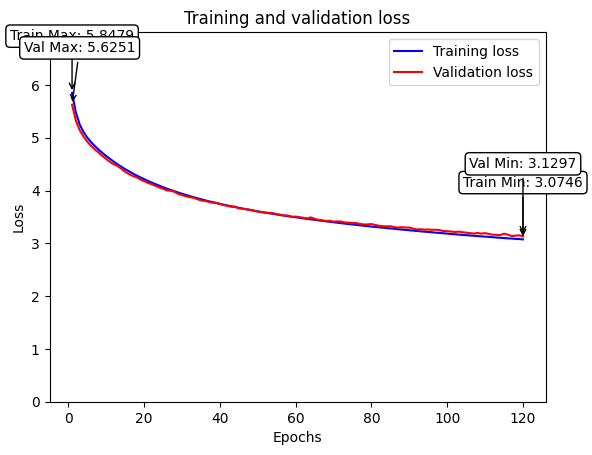

In [16]:
loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validation loss

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add maximum and minimum values for training loss
max_loss = max(loss)
min_loss = min(loss)
max_loss_epoch = loss.index(max_loss) + 1
min_loss_epoch = loss.index(min_loss) + 1

plt.annotate(f'Train Max: {max_loss:.4f}', xy=(max_loss_epoch, max_loss), xytext=(max_loss_epoch, max_loss+1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Train Min: {min_loss:.4f}', xy=(min_loss_epoch, min_loss), xytext=(min_loss_epoch, min_loss+1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

# Add maximum and minimum values for validation loss
max_val_loss = max(val_loss)
min_val_loss = min(val_loss)    
max_val_loss_epoch = val_loss.index(max_val_loss) + 1
min_val_loss_epoch = val_loss.index(min_val_loss) + 1

plt.annotate(f'Val Max: {max_val_loss:.4f}', xy=(max_val_loss_epoch, max_val_loss), xytext=(max_val_loss_epoch+2, max_val_loss+1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Val Min: {min_val_loss:.4f}', xy=(min_val_loss_epoch, min_val_loss), xytext=(min_val_loss_epoch, min_val_loss+1.3),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

plt.ylim(0, 7)  # Set the y-axis limits between 0 and 1

plt.show()



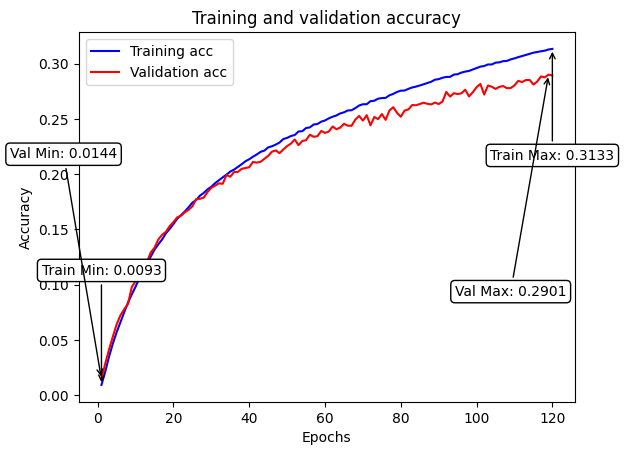

In [17]:
acc = history.history['accuracy'] # training accuracy
val_acc = history.history['val_accuracy'] # validation accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add maximum and minimum values for training accuracy
max_acc = max(acc)
min_acc = min(acc)
max_acc_epoch = acc.index(max_acc) + 1
min_acc_epoch = acc.index(min_acc) + 1

plt.annotate(f'Train Max: {max_acc:.4f}', xy=(max_acc_epoch, max_acc), xytext=(max_acc_epoch, max_acc-0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Train Min: {min_acc:.4f}', xy=(min_acc_epoch, min_acc), xytext=(min_acc_epoch, min_acc+0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

# Add maximum and minimum values for validation accuracy
max_val_acc = max(val_acc)
min_val_acc = min(val_acc)
max_val_acc_epoch = val_acc.index(max_val_acc) + 1
min_val_acc_epoch = val_acc.index(min_val_acc) + 1

plt.annotate(f'Val Max: {max_val_acc:.4f}', xy=(max_val_acc_epoch, max_val_acc), xytext=(max_val_acc_epoch-10, max_val_acc-0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')
plt.annotate(f'Val Min: {min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc), xytext=(min_val_acc_epoch-10, min_val_acc+0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), horizontalalignment='center')

plt.show()


In [18]:
# 모델 저장
# model.save('E:\Pill Project\model/AlexNet_10_31_data18_batch16_epoch30_m2.h5')

SAVED_MODEL_PATH = 'E:\Pill Project\model_h5/ResNet50_11_30_data400_batch64_epoch120_m1_pre.h5'
export_path = os.path.join(SAVED_MODEL_PATH)

tf.keras.models.save_model(
  model,
  export_path,
  overwrite=True,
  include_optimizer=True,
  save_format=None,
  signatures=None,
  options=None
)
print('\nSaved model:')

c:\Users\LEE\anaconda3\envs\cnn\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



Saved model:


In [21]:
# 저장된 모델 파일 로드
model = models.load_model('E:\Pill Project\model_h5/ResNet50_11_30_data400_batch64_epoch120_m1_pre.h5')

In [22]:
# 테스트셋 평가
results = model.evaluate(test_generator)
results

405/405 [==============================] - 250s 616ms/step - loss: 3.1324 - accuracy: 0.2918


[3.132406711578369, 0.291782408952713]

In [30]:
# 테스트셋 예측
results = model.predict(test_generator)
results


array([[0.0000000e+00, 6.7517599e-34, 0.0000000e+00, ..., 0.0000000e+00,
        5.4453811e-36, 6.4441246e-26],
       [4.7104237e-30, 2.4400703e-26, 3.8407118e-29, ..., 1.4998909e-21,
        1.2567253e-27, 1.2149968e-20],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.7676101e-31],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.4061440e-34, 0.0000000e+00, ..., 0.0000000e+00,
        1.3848214e-26, 2.4400465e-38],
       [2.7035816e-23, 1.8130349e-10, 1.7338660e-20, ..., 9.5538569e-30,
        6.7365394e-28, 1.1803977e-27]], dtype=float32)

In [31]:
# 예측값을 인덱스로 변환
results = np.argmax(results, 1)
results

array([386, 280, 194, ...,  98, 102, 117], dtype=int64)

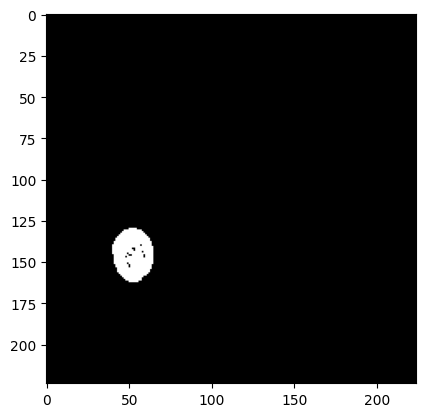

In [32]:
# 테스트셋에서 배치를 생성
for data_batch, labels_batch in test_generator:
    break
    
# 테스트셋의 첫 번째 이미지 출력
image = data_batch[0]

plt.imshow(image)
plt.show()


In [33]:
# 테스트셋 배치 데이터를 예측
results = model.predict(data_batch)

# 테스트셋의 첫 번째 라벨 이름 출력
labels_list[np.argmax(results[0])]


NameError: name 'labels_list' is not defined